In [1]:
# train density estimators on various datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import os
import datasets
from time import time
from sklearn.datasets import make_moons


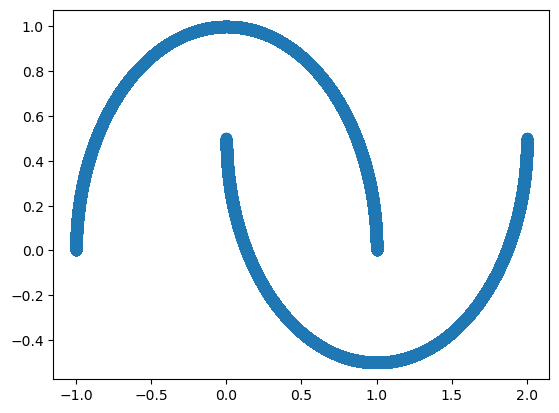

In [2]:

X, _ = make_moons(n_samples=300000, noise=0
            , random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
x0 = torch.tensor(X, dtype=torch.float32)

In [4]:
X

array([[-0.70995558,  0.70424646],
       [ 0.91777018,  0.39711195],
       [ 0.78771997,  0.61603348],
       ...,
       [-0.83957986,  0.54323628],
       [ 0.00117519,  0.45153342],
       [-0.78307886,  0.62192242]])

In [5]:
class Epsilon(nn.Module):
    """Neural network model for noise prediction"""

    def __init__(
        self,
        nfeatures,
        ntargets,
        nlayers,
        hidden_size,
        activation,
    ):
        super().__init__()
        layers = []

        # Input layer
        layer = nn.Linear(nfeatures, hidden_size)
        layers.append(layer)

        # Activation function for input layer
        layers.append(self._get_activation(activation))

        # Hidden layers
        for _ in range(nlayers - 1):
            layer = nn.Linear(hidden_size, hidden_size)
            layers.append(layer)
            layers.append(self._get_activation(activation))

        # Output layer
        layers.append(nn.Linear(hidden_size, ntargets))

        self.model = nn.Sequential(*layers)

    def _get_activation(self, activation):
        activations = {
            "LeakyReLU": nn.LeakyReLU(negative_slope=0.3),
            "ReLU": nn.ReLU(),
            "PReLU": nn.PReLU(),
            "ReLU6": nn.ReLU6(),
            "ELU": nn.ELU(),
            "SELU": nn.SELU(),
            "CELU": nn.CELU()
        }
        return activations.get(activation, nn.ReLU()) #default to ReLU if activation is not found

    def forward(self, x):
        return self.model(x)


There are many notations and interpretations in the literature for diffusion models. We use the one in [1]. Diffusion models are denoisers

- you start with an image $x_0$
- $x_T$ is the pure noise image, aka the latent space (same size as the original image), which is pure gaussian noise. 
- you add gaussian noise to it step by step
- $x_t$: noisy data at time step $t$
- you try to learn the model that goes in the opposite direction (i.e. removes the noise)
If you can do this well, then you can start with a pure noise image and denoise it to a clean realistic image. Or, if you have a low-quality image, you can denoise it to a high-quality image.

Following the diagram in [1]:

**REVERSE PROCESS (denoising)**: $x_T$ -> $x_{T-1}$ -> $x_{T-2}$ -> ... -> $x_0$ 
    This is described by 
    $$p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta\left(\mathbf{x}_t, t\right), \boldsymbol{\Sigma}_\theta\left(\mathbf{x}_t, t\right)\right)$$
    $$p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$$
    - here is where the learning happens. We want a model that can learn $x_{t-1} | x_t$, by learning the parameters of the gaussian distribution.

**FORWARD PROCESS (noising):** $x_T$ <- $x_{T-1}$ <- $x_{T-2}$ <- ... <- $x_0$ 
    This is described by 
    $$q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right):=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{1-\beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}\right)$$
    $$q\left(\mathbf{x}_{1: T} \mid \mathbf{x}_0\right):=\prod_{t=1}^T q\left(\mathbf{x}_t \mid \mathbf{x}_{t-1}\right)$$
- here you effectively shrink down the mean at each step, and add gaussian noise to the variance at each step.
    
- nothing to be learned here.
- $\beta_1, \ldots, \beta_T$ is the added noise at each time step, and $\alpha_t:=1-\beta_t$, $\bar
{\alpha}_t:=\prod_{s=1}^t \alpha_s$
- in the paper they choose $T=1000, \beta_1=10^{-4} \text { to } \beta_T=0.02$

```mermaid
graph TD;
    A-->B;
    A-->C;
    B-->D;
    C-->D;
```

## Training
repeat
1. $\mathbf{x}_0 \sim q\left(\mathbf{x}_0\right)$ (sample an image)
2. $t \sim \operatorname{Uniform}(\{1, \ldots, T\})$ (sample a time step)
3. $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ (sample gaussian noise)
4. create a an image with noise added to it: $ \mathbf{x}_t=\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}$
    
    - where $\beta_1, \ldots, \beta_T$ is the added noise at each time step, and $\alpha_t:=1-\beta_t$, $\bar{\alpha}_t:=\prod_{s=1}^t \alpha_s$.

5. Take gradient descent step on
$$\nabla_\theta\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2$$

- $\epsilon_\theta$ is a NN that tries to recover the noise that was applied $\epsilon$. This is equivalent to recovering the original image, because once you know what noise was applied to it, you can subtract it out from the noisy image and get the original image.

until converged


## Sampling (denoising, Langevin sampling)

1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
2. for $t=T, T-1, \ldots, 1$ do
3. $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \text { if } t>1, \text { else } \mathbf{z}=\mathbf{0}$
4. $\mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z}$

where $\sigma_t = \sqrt{\beta_t}$

5. end for
6. return $\mathbf{x}_0$


## References

[1] Denoising Diffusion Probabilistic Models (DDPM, Jonathan Ho, Ajay Jain, Pieter Abbeel. NeurIPS 2020


In [6]:
# total time steps T
T=1000
# come up with noise scheduler beta_t, which goes from beta_1 to beta_T
beta_1=1E-4
beta_T=0.02
beta = torch.linspace(beta_1, beta_T, T)
alpha = 1 - beta
alpha

tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9995, 0.9995, 0.9995, 0.9995, 0.9995, 0.9994, 0.9994, 0.9994, 0.9994,
        0.9994, 0.9993, 0.9993, 0.9993, 0.9993, 0.9993, 0.9992, 0.9992, 0.9992,
        0.9992, 0.9992, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9985, 0.9985, 0.9985, 0.9985,
        0.9985, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9983, 0.9983,
        0.9983, 0.9983, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9981, 0.9981,
        0.9981, 0.9981, 0.9981, 0.9980, 0.9980, 0.9980, 0.9980, 0.9980, 0.9979,
        0.9979, 0.9979, 0.9979, 0.9979, 0.9978, 0.9978, 0.9978, 0.9978, 0.9978,
        0.9977, 0.9977, 0.9977, 0.9977, 

In [7]:
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar

tensor([9.9990e-01, 9.9978e-01, 9.9964e-01, 9.9948e-01, 9.9930e-01, 9.9910e-01,
        9.9888e-01, 9.9864e-01, 9.9838e-01, 9.9811e-01, 9.9781e-01, 9.9749e-01,
        9.9715e-01, 9.9679e-01, 9.9641e-01, 9.9602e-01, 9.9560e-01, 9.9516e-01,
        9.9471e-01, 9.9423e-01, 9.9374e-01, 9.9322e-01, 9.9269e-01, 9.9213e-01,
        9.9156e-01, 9.9097e-01, 9.9035e-01, 9.8972e-01, 9.8907e-01, 9.8840e-01,
        9.8771e-01, 9.8700e-01, 9.8627e-01, 9.8553e-01, 9.8476e-01, 9.8398e-01,
        9.8317e-01, 9.8235e-01, 9.8151e-01, 9.8065e-01, 9.7977e-01, 9.7887e-01,
        9.7795e-01, 9.7702e-01, 9.7606e-01, 9.7509e-01, 9.7410e-01, 9.7309e-01,
        9.7206e-01, 9.7102e-01, 9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01,
        9.6551e-01, 9.6436e-01, 9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01,
        9.5832e-01, 9.5706e-01, 9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01,
        9.5050e-01, 9.4914e-01, 9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01,
        9.4207e-01, 9.4060e-01, 9.3912e-

In [8]:
def get_x_t(x0, t):
    """
    get the real image and the noise that was added to it at time t
    """
    if not isinstance(x0, torch.Tensor):
        x0 = torch.tensor(x0)
    epsilon = torch.randn_like(x0)
    xt = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * epsilon
    return xt, epsilon


t=0plot_idx=0
t=100plot_idx=1
t=200plot_idx=2
t=300plot_idx=3
t=400plot_idx=4
t=500plot_idx=5
t=600plot_idx=6
t=700plot_idx=7
t=800plot_idx=8
t=900plot_idx=9


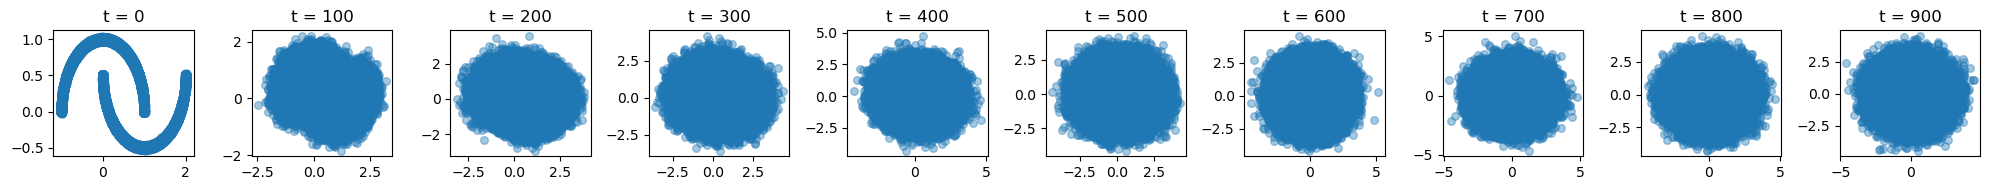

In [9]:
def plot_forward_xt(T_ex, x0, N_plots=10):
    fig, axs = plt.subplots(1,N_plots, figsize=(20, 2))
    den = T_ex / N_plots
    for t in range(0, T_ex):
        if t % den == 0:
            
            xt, epsilon = get_x_t(x0, t)
            plot_idx = int(t // den)
            
            print(f't={t}' \
            f'plot_idx={plot_idx}')
            axs[plot_idx].set_title(f't = {t}')
            axs[plot_idx].scatter(xt[:, 0], xt[:, 1], s=30, alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_forward_xt(T_ex=T, x0=x0, N_plots=10)

In [10]:
def sample_one_t():
    return torch.randint(low=1, high=T, size=(1,))

def sample_array_t(n):
    return torch.randint(low=1, high=T, size=(n,))
sample_one_t()

tensor([894])

In [11]:
sample_array_t(10)

tensor([188, 142, 895, 140, 472, 168, 688, 699,  68, 104])

In [12]:
def sample_one(model):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(x0.shape)
        for i in reversed(range(1, T)):
            t=i
            predicted_noise = model(x_t)
            alpha_t = alpha[t]
            alpha_bar_t = alpha_bar[t]
            beta_t = beta[t]
            sigma_t = torch.sqrt(beta_t)
            
            if i > 1:
                z = torch.randn_like(x_t)
            else:
                z = torch.zeros_like(x_t)
                
            x_t = 1/torch.sqrt(alpha_t) * (xt - (1-alpha_t)/(torch.sqrt(1-alpha_t)) * predicted_noise ) + sigma_t * z
            
    model.train()
    return x_t


In [13]:
epsilon = Epsilon(nfeatures=2, ntargets=1, nlayers=2, hidden_size=100, activation='ReLU')
x0.shape

torch.Size([300000, 2])

In [14]:

def train(epochs=100):
    epsilon_theta = Epsilon(nfeatures=x0.shape[1], 
                            ntargets=1, 
                            nlayers=2, 
                            hidden_size=100, 
                            activation='ReLU')
    optimizer = optim.Adam(epsilon_theta.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()  # Renamed to avoid conflict
    for epoch in range(epochs):
        # t = sample_one_t() # uncomment to sample one t
        t = sample_array_t(x0.shape[1])
        optimizer.zero_grad()
        x_t, noise = get_x_t(x0, t) 
        predicted_noise = epsilon_theta(x_t)  # Added t parameter
        loss = loss_fn(predicted_noise, noise)  # Use renamed loss function
        loss.backward()
        optimizer.step()
    return epsilon_theta



In [15]:
epsilon_theta = train(epochs=100)


/home/ali/miniconda3/envs/torch_1/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([300000, 2])) that is different to the input size (torch.Size([300000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

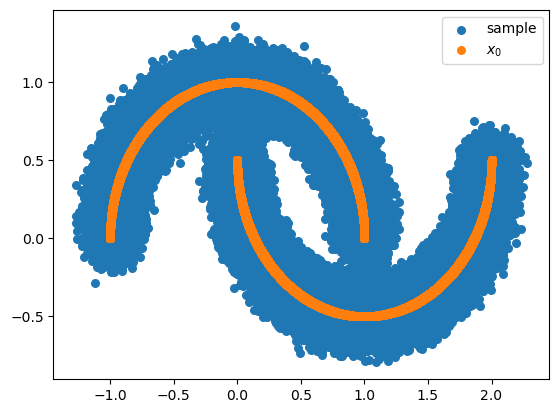

In [20]:
x_sample = sample_one(epsilon_theta)
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=30, label='sample');
plt.scatter(X[:, 0], X[:, 1], s=30, label='$x_0$');
plt.legend();



----
# JetNet

graph network


In [68]:
import jetnet
from jetnet.datasets import JetNet
from jetnet.utils import jet_features

from jetnet_diffusion import *
from configs import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


particle_data = np.load('datasets/jetnet/particle_data.npy')
print(f'particle_data.shape: {particle_data.shape}')

jet_data = np.load('datasets/jetnet/jet_data.npy')

print('using substructure')
if SUBSET is not None:
    jet_data = jet_data[:SUBSET]
    particle_data = particle_data[:SUBSET, :, :]

print(f'jet_data.shape: {jet_data.shape}')
print(f'particle_data.shape: {particle_data.shape}')
num_types = len(data_args["jet_type"])
print(f'num_types: {num_types}')
type_indices = {jet_type: JetNet.JET_TYPES.index(jet_type) for jet_type in data_args["jet_type"]}# these are special indices for gluon, top quark, and W boson jets
print(f'type_indices: {type_indices}') 


x0 = particle_data
if SUBSET is not None:
    x0_red = x0[:SUBSET]
else:
    x0_red = x0

flattened_x0 = x0_red.reshape(-1, 3)
flat_x0_red = torch.tensor(flattened_x0, dtype=torch.float32).to(device)
print(f'x0.shape={flat_x0_red.shape}')
# Total time steps T
T = 1000
# Noise scheduler beta_t, which goes from beta_1 to beta_T
beta_1 = 1e-4
beta_T = 0.02
beta = torch.linspace(beta_1, beta_T, T).to(device)
alpha_ = 1 - beta
alpha_bar = torch.cumprod(alpha_, dim=0)

    # Train the model
epsilon_theta, x0_mean, x0_std = train_substructure(model_type='gnn',
    epochs=epochs, 
                x0=flat_x0_red, 
                alpha_bar=alpha_bar, 
                T=T, 
                device=device)

Using device: cuda
particle_data.shape: (532369, 30, 3)
using substructure
jet_data.shape: (100000, 4)
particle_data.shape: (100000, 30, 3)
num_types: 3
type_indices: {'g': 0, 't': 2, 'w': 3}
x0.shape=torch.Size([3000000, 3])


TypeError: train_substructure() got an unexpected keyword argument 'model_type'

In [16]:
#sinusoidal embedding function for time steps
def sinusoidal_embedding(timesteps, embedding_dim):
    """
    Creates sinusoidal embeddings for the time steps.
    Look at "Attention is all you need" for more details.
    """
    device = timesteps.device
    half_dim = embedding_dim // 2
    emb = torch.exp(
        -torch.log(torch.tensor(10000.0)) * torch.arange(half_dim, device=device) / (half_dim - 1)
    )
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

In [17]:
flat_x0 = torch.randn(500,3)
flat_x0

tensor([[-0.6638, -0.5531,  0.6673],
        [ 0.3404,  0.4037,  0.5784],
        [-1.0232, -0.8777, -0.2116],
        ...,
        [ 1.1231,  0.5709, -0.7068],
        [ 1.0077, -0.1842, -1.4476],
        [ 0.8151,  0.4883,  0.7521]])

tensor([873, 904, 514, 156, 980, 614, 998, 961, 833, 834, 183, 289, 705, 762,
        715, 747, 531, 315, 817, 567, 236, 525, 321, 506, 212, 485, 160, 581,
        102,  19, 750, 992, 923, 825, 977, 398, 793, 468, 360, 573, 344, 388,
        917, 862, 107, 706, 141, 635, 483, 665, 793, 682, 574,  64, 685, 999,
        418, 859, 269, 473, 176, 152, 400, 814, 384, 787, 913, 715, 459, 919,
         70, 161, 825, 293, 960, 945,  73, 885, 461, 959, 258, 383, 673, 613,
        884, 764, 964, 489, 837, 965, 777, 958,  97, 775, 683, 355, 247, 328,
        554, 230, 862, 853, 649, 186, 431,  39,  58,   9, 330, 734, 695, 350,
        737, 727, 504, 999, 591, 836, 662, 846, 524, 799, 713,  83, 220,  55,
        906, 265, 273,   6, 342, 480, 840, 654, 769,  51, 570, 295, 507, 673,
        980, 505, 766, 457, 955, 930, 835, 730, 986, 156, 220, 890,   0, 718,
        753, 575, 129, 272, 923, 863, 718, 761, 501, 323, 882, 439, 295, 344,
         71, 478, 203, 426, 286, 105, 156, 400, 412,  29, 815, 8

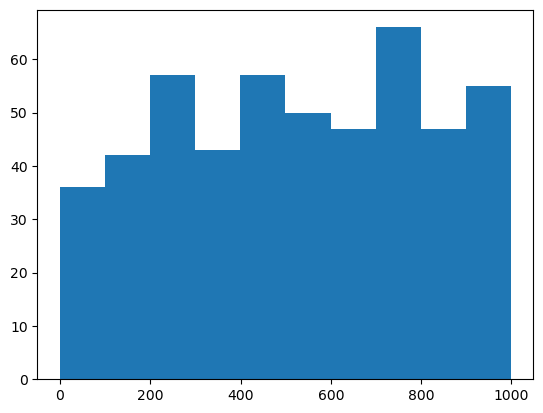

In [21]:
T=1000
t = torch.randint(low=0, high=T, size=(flat_x0.shape[0],))
print(t)
print(t.shape)
plt.hist(t)
plt.show()

In [22]:
time_embedding_dim=128
t_embedding = sinusoidal_embedding(t, time_embedding_dim)
print(t_embedding.shape)


torch.Size([500, 128])


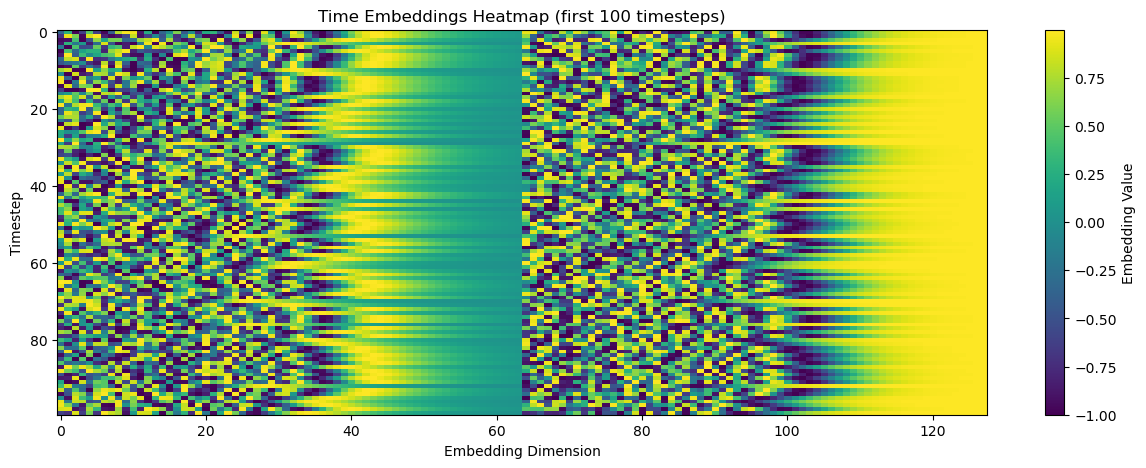

In [24]:
plt.figure(figsize=(15, 5))
plt.imshow(t_embedding[:100, :].detach().numpy(),
           aspect='auto',
           cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.title('Time Embeddings Heatmap (first 100 timesteps)')
plt.xlabel('Embedding Dimension')
plt.ylabel('Timestep')
# Optional: set tick frequency
plt.xticks(range(0, time_embedding_dim, 20))
plt.yticks(range(0, 100, 20))
plt.show()

In [27]:
t.shape

torch.Size([500])

In [28]:
t[:,None].shape

torch.Size([500, 1])

In [31]:
embedding_dim = time_embedding_dim
half_dim = embedding_dim // 2
emb = torch.exp(
    -torch.log(torch.tensor(10000.0)) * torch.arange(half_dim) / (half_dim - 1)
)

In [33]:
emb.shape

torch.Size([64])

In [34]:
emb[None, :].shape

torch.Size([1, 64])

In [36]:
emb = t[:, None] * emb[None, :]
emb.shape

torch.Size([1, 500, 64])

In [37]:
emb

tensor([[[7.6213e+05, 6.5847e+05, 5.6891e+05,  ..., 1.0210e+02,
          8.8211e+01, 7.6213e+01],
         [8.1722e+05, 7.0607e+05, 6.1003e+05,  ..., 1.0948e+02,
          9.4586e+01, 8.1722e+01],
         [2.6420e+05, 2.2826e+05, 1.9722e+05,  ..., 3.5392e+01,
          3.0579e+01, 2.6420e+01],
         ...,
         [3.2490e+05, 2.8071e+05, 2.4253e+05,  ..., 4.3525e+01,
          3.7605e+01, 3.2490e+01],
         [7.3441e+04, 6.3452e+04, 5.4822e+04,  ..., 9.8384e+00,
          8.5002e+00, 7.3441e+00],
         [7.9210e+05, 6.8437e+05, 5.9128e+05,  ..., 1.0611e+02,
          9.1679e+01, 7.9210e+01]]])

In [40]:
sin = torch.sin(emb)
cos = torch.cos(emb)
print(sin.shape)

torch.Size([1, 500, 64])


In [42]:
embedding = torch.cat([sin, cos], dim=1)
embedding.shape

torch.Size([1, 1000, 64])

In [43]:
from jetnet_diffusion import Epsilon
model = Epsilon(
    nfeatures=flat_x0.shape[1],
    ntargets=flat_x0.shape[1],
    nlayers=4,
    hidden_size=128,
    activation='ReLU',
    time_embedding_dim=128,
)

/home/ali/miniconda3/envs/torch_1/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/home/ali/Pulled_git_repositories/diffusionsimple/configs.py:23: SyntaxWarning: invalid escape sequence '\e'
  selected_observables_labels = ['$m^{rel}$', '$p_T^{rel}$', '$\eta^{rel}$']


In [44]:
model(flat_x0, t_embedding)

tensor([[0.0091, 0.0823, 0.0877],
        [0.0222, 0.0842, 0.0940],
        [0.0055, 0.0745, 0.0877],
        ...,
        [0.0079, 0.0894, 0.1080],
        [0.0230, 0.0883, 0.0941],
        [0.0242, 0.0893, 0.1077]], grad_fn=<AddmmBackward0>)

In [67]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

class GNN(nn.Module):
    def __init__(
        self,
        nfeatures,
        ntargets,
        nlayers,
        hidden_size,
        activation,
        time_embedding_dim=128,
    ):
        super().__init__()
        self.time_embedding_dim = time_embedding_dim

        # Time embedding layer
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_size),
            self._get_activation(activation),
        )

        # Input layer for x_t
        self.conv1 = GCNConv(nfeatures, hidden_size)
        
        # Hidden layers
        self.convs = nn.ModuleList()
        for _ in range(nlayers - 1):
            self.convs.append(GCNConv(hidden_size, hidden_size))
        
        self.activation = self._get_activation(activation)
        # Output layer
        self.output_layer = nn.Linear(hidden_size, ntargets)

    def _get_activation(self, activation):
            activations = {
                "LeakyReLU": nn.LeakyReLU(negative_slope=0.3),
                "ReLU": nn.ReLU(),
                "PReLU": nn.PReLU(),
                "ReLU6": nn.ReLU6(),
                "ELU": nn.ELU(),
                "SELU": nn.SELU(),
                "CELU": nn.CELU(),
            }
            return activations.get(activation, nn.ReLU())  # Default to ReLU if activation is not found

    def forward(self, x, edge_index, t_embedding):
        # Process time embedding
        t_emb = self.time_mlp(t_embedding)
        
        # Initial convolution
        h = self.conv1(x, edge_index)
        h = self.activation(h)
        h = h + t_emb  # Add time embedding
        
        # Hidden layers
        for conv in self.convs:
            h = conv(h, edge_index)
            h = self.activation(h)
        
        return self.output_layer(h)

IndentationError: expected an indented block after function definition on line 8 (3921964968.py, line 17)

In [58]:
model_gnn = GNN(
    nfeatures=flat_x0.shape[1],
    ntargets=flat_x0.shape[1],
    nlayers=4,
    hidden_size=128,
    activation='ReLU',
    time_embedding_dim=128,
)

In [64]:
num_nodes = flat_x0.shape[0]
print(num_nodes)
edge_index = torch.combinations(torch.arange(num_nodes),r=2).t()
edge_index.shape

500


torch.Size([2, 124750])

In [65]:
edge_index

tensor([[  0,   0,   0,  ..., 497, 497, 498],
        [  1,   2,   3,  ..., 498, 499, 499]])

In [66]:
model_gnn(x=flat_x0, edge_index=edge_index, t_embedding=t_embedding)

tensor([[-0.0758,  0.1824, -0.1200],
        [-0.0940,  0.2130, -0.1368],
        [-0.1076,  0.2315, -0.1489],
        ...,
        [-0.2660,  0.3752, -0.1872],
        [-0.2660,  0.3752, -0.1872],
        [-0.2661,  0.3752, -0.1871]], grad_fn=<AddmmBackward0>)